In [44]:
import scomv
import stlearn as st
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import pandas as pd
import numpy as np
import anndata
import scanpy as sc

In [1]:
cd /Users/nomura/SpatialCompassV/docs/tutorials/

/Users/nomura/SpatialCompassV/docs/tutorials


/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
#!mkdir tutorial_data
#!mkdir tutorial_data/xenium_data
#!wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
#!wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz

In [6]:
# Load Xenium data using stlearn
adata = st.ReadXenium(
    feature_cell_matrix_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5",
    cell_summary_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz",
    library_id="example data",
    image_path=None,
    scale=1,
    spot_diameter_fullres=10
)

In [10]:
# Gridding at 10μm interval using stlearn
N_COL = int((adata.obs.imagecol.max() - adata.obs.imagecol.min()) / 10)
N_ROW = int((adata.obs.imagerow.max() - adata.obs.imagerow.min()) / 10)
grid = st.tl.cci.grid(adata, n_row=N_ROW, n_col=N_COL, n_cpus=10, verbose=False)

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (1316537549.py, line 2)

In [15]:
from scomv.preparation.skny_calc_distance import calculate_distance

In [16]:
## apply SKNY
grid = calculate_distance(
    grid, pos_marker_ls=['CDH1',"EPCAM"],
)

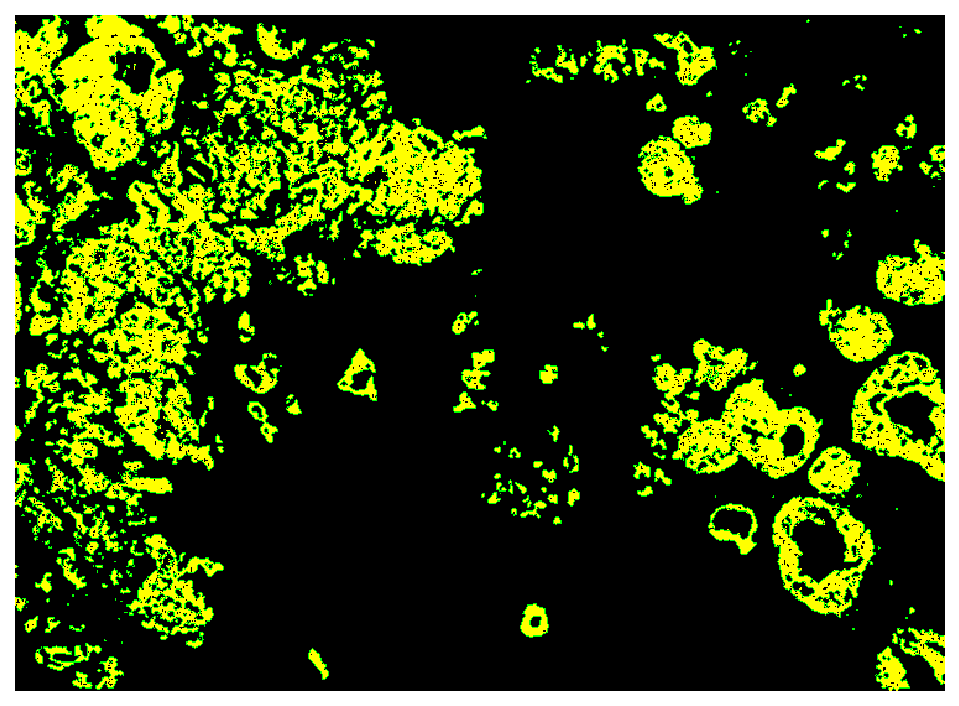

In [22]:
# Figure 2B
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.imshow(cv2.cvtColor(grid.uns["marker_median_delineation"], cv2.COLOR_BGR2RGB),
          interpolation="nearest")
ax.axis("off")
plt.show()

#plt.savefig("Figure_2B.png", dpi=300)

In [27]:
# annotation each section to obs object
df_shotest = getattr(grid, "shortest")
df_grid = grid.to_df()

# extract grid info
df_grid = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]),
    df_grid, right_index=True, left_index=True, how="left"
).fillna(np.nan)

# extract section info
df_region = pd.DataFrame(
    np.array(df_shotest["region"]).reshape(N_ROW, N_COL).T.reshape(N_ROW * N_COL),
    index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)], columns=["region"]
)

# marge
df_grid_region = pd.merge(
    df_grid, df_region,
    right_index=True, left_index=True, how="left"
)
df_grid_region = df_grid_region.dropna()

# add to obs
grid.obs = pd.merge(
    grid.obs, df_grid_region[["region"]],
    right_index=True, left_index=True, how="left"
)

# shaping
grid.obs["region_10"] = [str(i*10) for i in grid.obs["region"]]
grid.obs["region_10"] = ["("+str(int(float(i.split(", ")[0][1:])))+", "+str(int(float(i.split(", ")[-1][:-1])))+"]" if i != "nan" else np.nan for i in grid.obs["region_10"]]
# exclude because of small number
grid.obs["region_10"] = grid.obs["region_10"].replace(
    {"(-150, -120]": np.nan}
)

In [28]:
from scomv.preparation.choose_roi import extract_roi, contour_regions

In [29]:
# select ROI
roi = (2400, 3400, 2400, 3800)

subset_grid, filtered_shortest, xy_list = extract_roi(
    grid=grid,
    roi=roi,
    bin_size=10,
    region_col="region_10",
)


In [30]:
g_x_cont, g_y_cont, g_x_inside, g_y_inside = contour_regions(
    filtered_shortest, adata,
    min_x=0, max_x=4000, min_y=0, max_y=4000,
    out_dir_base="./roi_plots",
    show=False,
)

In [31]:
from scomv.preparation.scomv_calc_vector import compute_min_vectors_polar

In [32]:
outline_points = list(zip(g_x_cont, g_y_cont))
inside_points  = list(zip(g_x_inside, g_y_inside))

min_vector_df = compute_min_vectors_polar(
    xy_list=xy_list,
    outline_points=outline_points,
    inside_points=inside_points,
    invert_y=True,
    make_inside_negative=True,
)

In [36]:
# load cell_annotation file
file_path = "./tutorial_data/Cell_Barcode_Type_Matrices.xlsx"
xls = pd.ExcelFile(file_path)
cell_ann_df = pd.read_excel(file_path, sheet_name=xls.sheet_names[3])
print(cell_ann_df.head())

adata_obs = adata.obs
cell_ann_df.index = cell_ann_df.index + 1
adata_obs = adata_obs[["imagecol", "imagerow"]]
adata_obs.index = adata_obs.index.astype(int)


cell_df = pd.concat([adata_obs, cell_ann_df], axis=1)
cell_df = cell_df[["imagecol", "imagerow", "Cluster"]]
cell_df["Cluster"].unique()
#cell_df.to_csv("cell_annotation_df.csv")

   Barcode         Cluster
0        1          DCIS_2
1        2          DCIS_2
2        3       Unlabeled
3        4  Invasive_Tumor
4        5          DCIS_2


array(['DCIS_2', 'Unlabeled', 'Invasive_Tumor', 'Macrophages_1',
       'Stromal', 'DCIS_1', 'Myoepi_ACTA2+', 'CD8+_T_Cells',
       'Endothelial', 'Prolif_Invasive_Tumor', 'T_Cell_&_Tumor_Hybrid',
       'Mast_Cells', 'CD4+_T_Cells', 'B_Cells', 'Macrophages_2',
       'Stromal_&_T_Cell_Hybrid', 'Perivascular-Like', 'LAMP3+_DCs',
       'IRF7+_DCs', 'Myoepi_KRT15+', nan], dtype=object)

In [37]:
from scomv.cell_pipeline import CellPolarPipeline

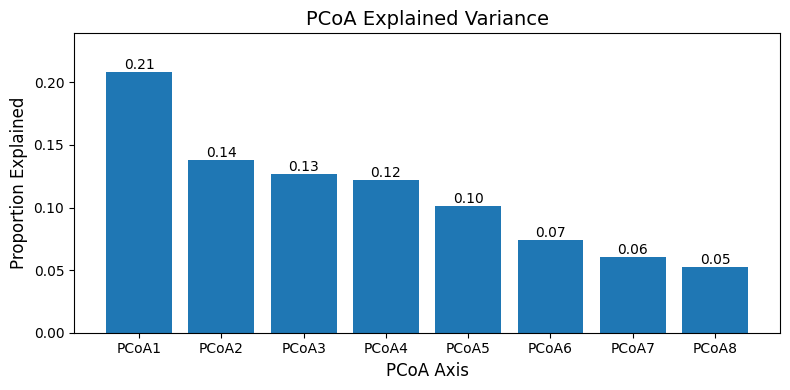

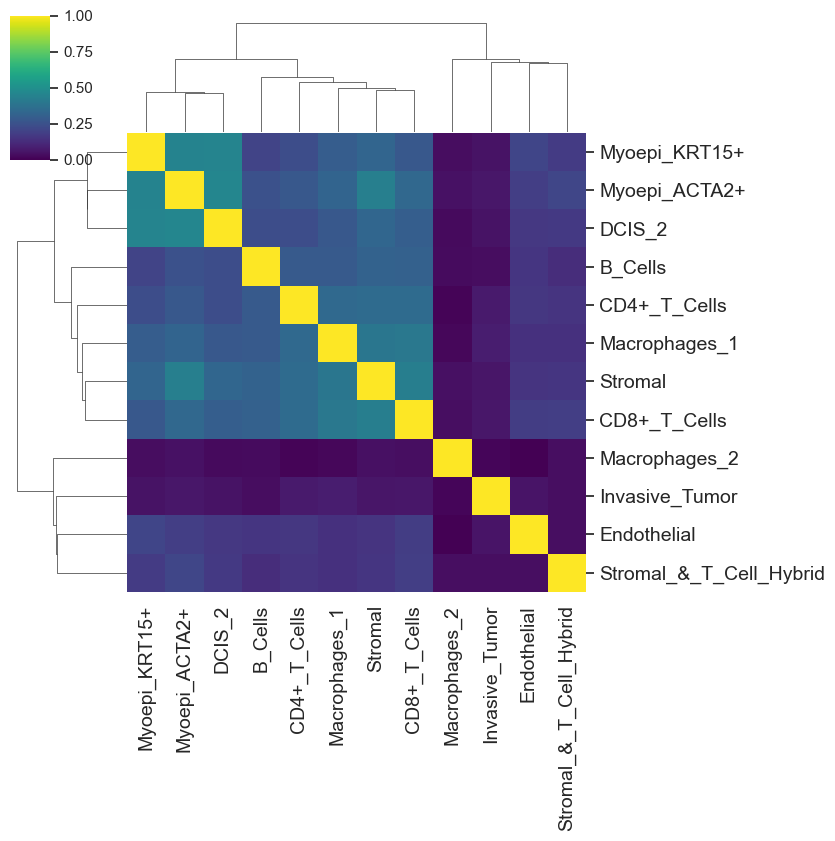

In [38]:
# Initialize the pipeline with cell-level data and precomputed minimum-distance vectors
cell_pipe = CellPolarPipeline(
    cell_df=cell_df,
    min_vector_df=min_vector_df
)

# Run the pipeline for a specified ROI (xmin, xmax, ymin, ymax)
# Disable histogram plotting during the run
cell_out = cell_pipe.run(
    roi=(2400, 3400, 2400, 3800),
    plot_hist=False
)

# Distance matrix between cells based on polar-vector representations
dist = cell_pipe.dist_df

# Plot explained variance of PCoA components
cell_pipe.plot_explained_variance(n_components=8)

# Plot a heatmap of similarities (displayed as 1 - distance)
cell_pipe.heatmap(font_size=14, figsize=(8, 8))


/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


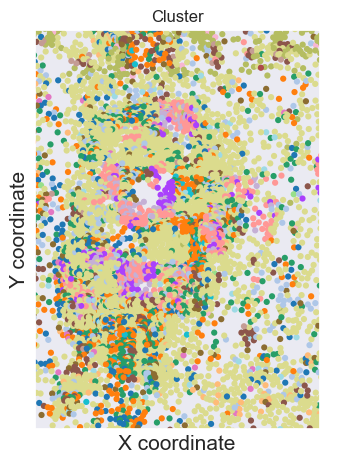

In [41]:
adata_2 = anndata.AnnData(X=np.zeros((len(cell_df), 0)))  # Dummy X
adata_2.obs = cell_df.copy()

# Store the coordinates used as the basis in adata.obsm
adata_2.obsm["spatial"] = cell_df[["imagecol", "imagerow"]].to_numpy()

# draw
sc.pl.embedding(
    adata_2,
    basis="spatial",
    color="Cluster",
    size=80,
    legend_loc=None,
    frameon=True,
    show=False,
)

ax = plt.gca()
ax.set_xlabel("X coordinate", fontsize=15)
ax.set_ylabel("Y coordinate", fontsize=15)
ax.tick_params(axis="both", labelsize=13)

# limit the range
ax.set_xlim(2400, 3400)
ax.set_ylim(2400, 3800)

# Align to the image coordinate system
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")

legend = ax.legend(
    *ax.get_legend_handles_labels(),
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=12
)
plt.tight_layout()
plt.show()


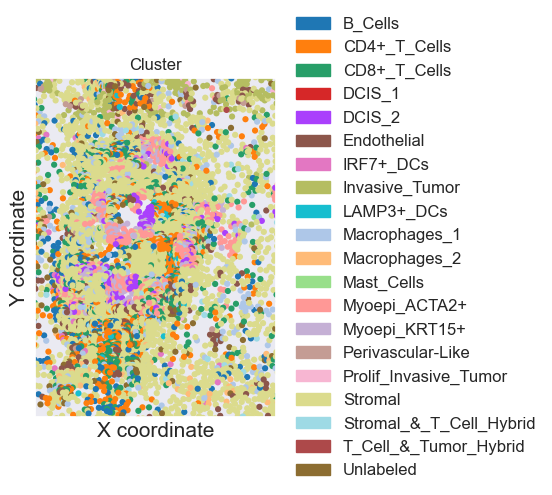

In [45]:
sc.pl.embedding(
    adata_2,
    basis="spatial",
    color="Cluster",
    size=80,
    legend_loc="none",
    frameon=True,
    show=False,
)

ax = plt.gca()
ax.set_xlabel("X coordinate", fontsize=15)
ax.set_ylabel("Y coordinate", fontsize=15)
ax.tick_params(axis="both", labelsize=13)
ax.set_xlim(2400, 3400)
ax.set_ylim(2400, 3800)
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")

# Retrieve category names and colors stored in adata
cats = adata_2.obs["Cluster"].astype("category").cat.categories
colors = adata_2.uns.get("Cluster_colors")

handles = [mpatches.Patch(color=c, label=str(cat)) for c, cat in zip(colors, cats)]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=12)

plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_2_renamed.obs["Cluster"].replace({"DCIS_2": "DCIS"}).astype("category")
/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

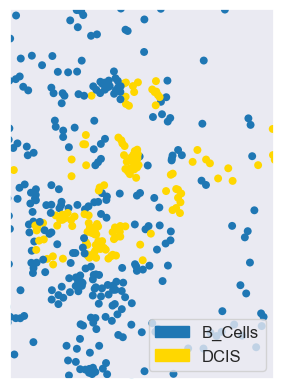

Figure: B_Cells + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

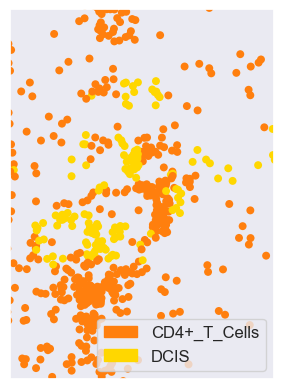

Figure: CD4+_T_Cells + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

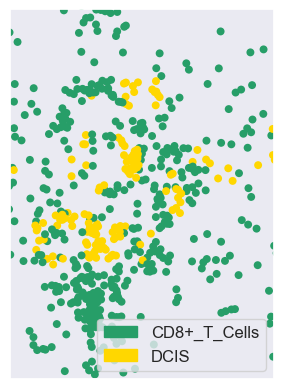

Figure: CD8+_T_Cells + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

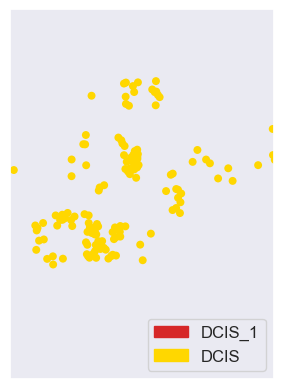

Figure: DCIS_1 + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

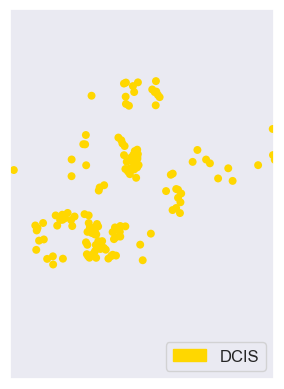

Figure: DCIS + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

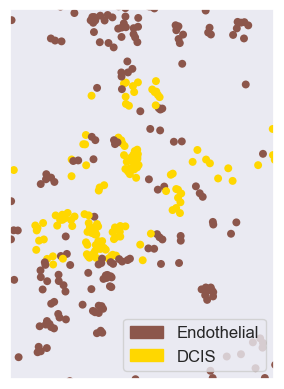

Figure: Endothelial + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

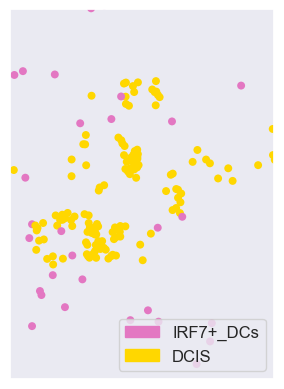

Figure: IRF7+_DCs + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

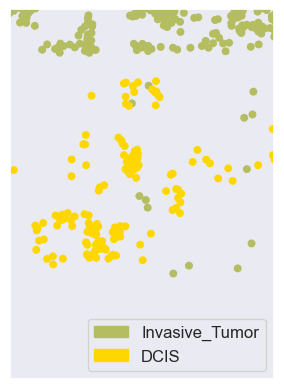

Figure: Invasive_Tumor + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

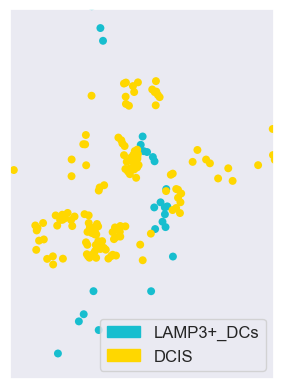

Figure: LAMP3+_DCs + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

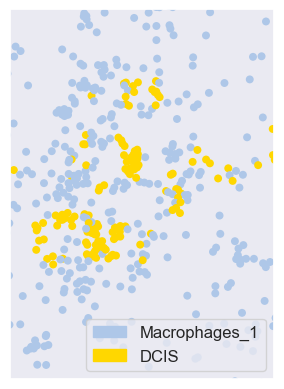

Figure: Macrophages_1 + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

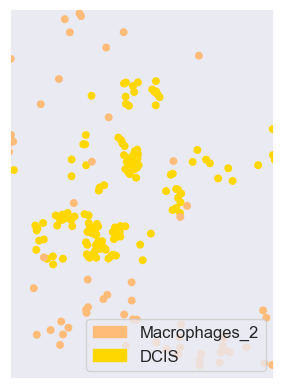

Figure: Macrophages_2 + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

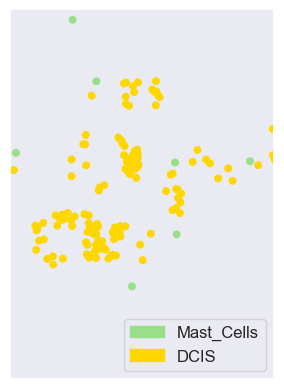

Figure: Mast_Cells + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

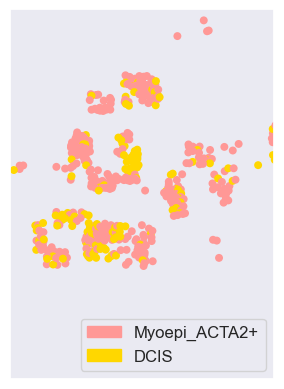

Figure: Myoepi_ACTA2+ + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

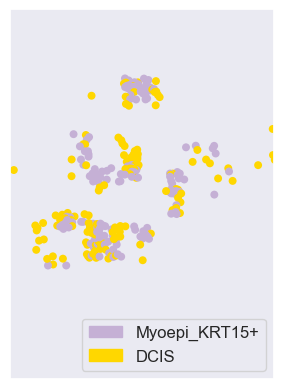

Figure: Myoepi_KRT15+ + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

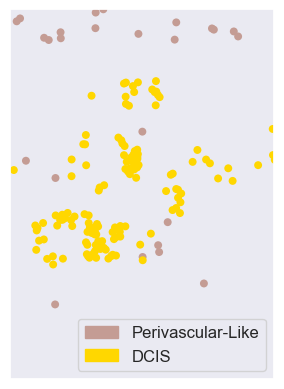

Figure: Perivascular-Like + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

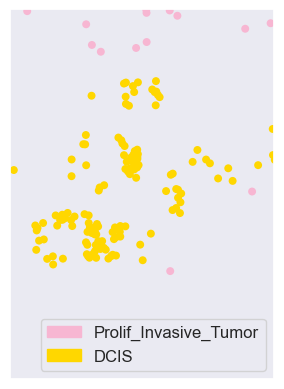

Figure: Prolif_Invasive_Tumor + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

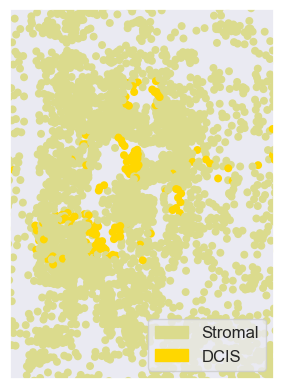

Figure: Stromal + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

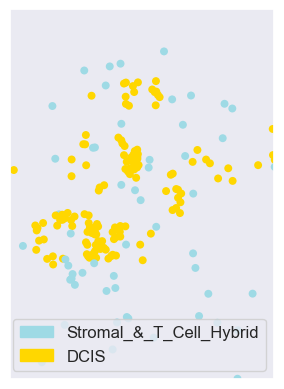

Figure: Stromal_&_T_Cell_Hybrid + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

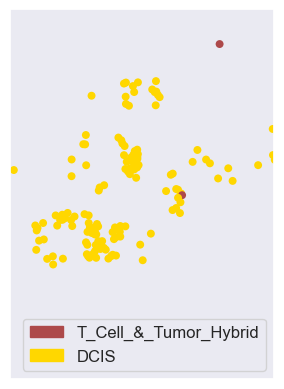

Figure: T_Cell_&_Tumor_Hybrid + DCIS


/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_65308/3277719802.py:31: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


<Figure size 1000x1000 with 0 Axes>

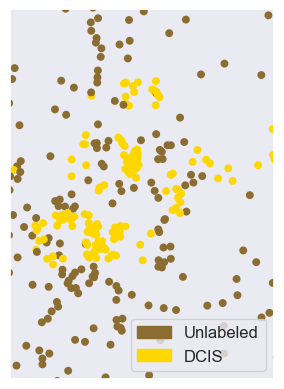

Figure: Unlabeled + DCIS


In [46]:
# List of cluster categories
clusters = adata_2.obs["Cluster"].astype("category").cat.categories

# Create a copy of adata and rename DCIS_2 → DCIS
adata_2_renamed = adata_2.copy()
adata_2_renamed.obs["Cluster"] = (
    adata_2_renamed.obs["Cluster"].replace({"DCIS_2": "DCIS"}).astype("category")
)

# Color settings: DCIS in yellow, others keep original colors
orig_cats = adata_2.obs["Cluster"].astype("category").cat.categories
orig_colors = adata_2.uns["Cluster_colors"]
color_dict = dict(zip(orig_cats, orig_colors))

cats = list(adata_2_renamed.obs["Cluster"].cat.categories)
colors = []
for c in cats:
    if c == "DCIS":
        colors.append("#FFD700")
    else:
        orig_name = "DCIS_2" if c == "DCIS" and "DCIS_2" in orig_cats else c
        colors.append(color_dict.get(orig_name, "gray"))

adata_2_renamed.uns["Cluster_colors"] = colors

# Plot "DCIS + each cluster" separately
for cluster in clusters:
    cluster_name = "DCIS" if cluster == "DCIS_2" else cluster

    plt.figure(figsize=(10, 10))
    sc.pl.spatial(
        adata_2_renamed[adata_2_renamed.obs["Cluster"].isin([cluster_name, "DCIS"])],
        img_key="hires",
        color="Cluster",
        size=1.5,
        spot_size=20,
        legend_loc="lower right",
        frameon=True,
        show=False,
    )

    ax = plt.gca()

    # Remove axis titles and labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", labelsize=11)

    # Manually construct legend for selected clusters
    handle_map = {cat: col for cat, col in zip(cats, adata_2_renamed.uns["Cluster_colors"])}
    show_labels = [cluster_name, "DCIS"]
    show_labels = list(dict.fromkeys(show_labels))  # Remove duplicates for DCIS plots
    handles = [
        mpatches.Patch(color=handle_map[label], label=label)
        for label in show_labels
    ]
    ax.legend(handles=handles, loc="lower right", frameon=True, fontsize=12)

    ax.set_axis_on()

    # Set ROI limits
    ax.set_xlim(2400, 3400)
    # ax.set_xticks(range(2400, 3401, 200))
    ax.set_ylim(2400, 3800)
    # ax.set_yticks(range(2400, 3801, 200))

    # Align to image coordinate system
    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")

    # Save figure (optional)
    # plt.savefig(f"{root}/cell_location_fig/{cluster_name}_no_tick.png", dpi=300)

    plt.show()
    print(f"Figure: {cluster_name} + DCIS")
